In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
FILENAMES = ['participants','blood_pressure','heart_rate','hrv_measurements','surveys','scales_description','sleep','wearables','weather']
URL = 'https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/'
EXTENSION = '.csv'
dfs = {}
for fn in FILENAMES:
  dfs[fn] = pd.read_csv(URL + fn + EXTENSION)

# Preprocessing

## Covid

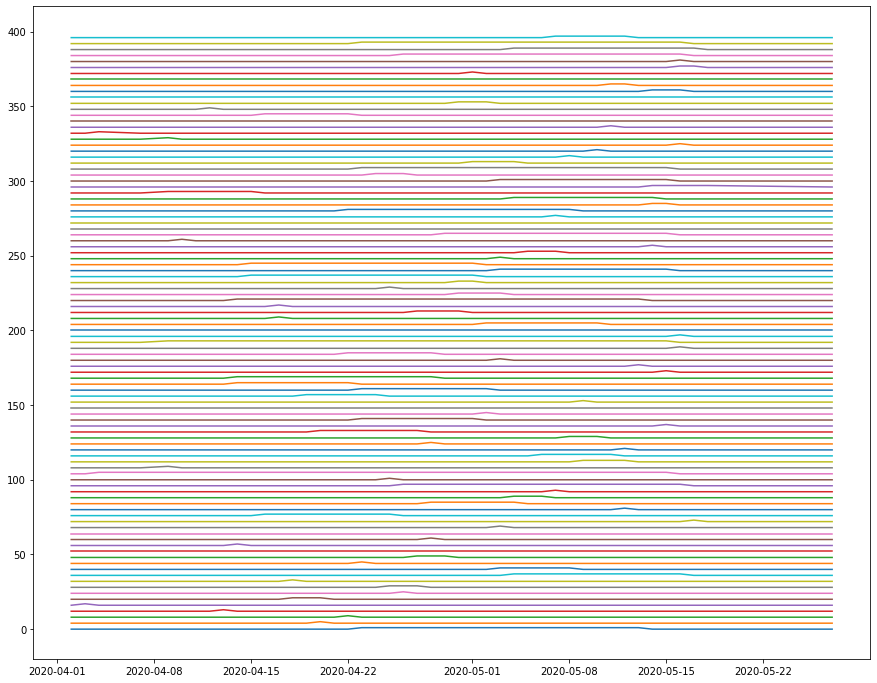

In [ ]:
# Mapping for covid variables
# https://github.com/Welltory/hrv-covid19/blob/master/data/scales_description.csv
vals = {'H': 1, 'M': 1, 'L': 0}
keys = ['S_CORONA', 'S_COVID_OVERALL'] 
maps = [{1: 'H', 2: 'H', 3: 'M', 4: 'L', 5: 'L'},
        {1: 'L', 2: 'M', 3: 'M', 4: 'H', 5: 'H', 6: 'H'}]

# Initial processing 
df = dfs['surveys'].copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.loc[df['scale'].isin(keys)]
for i, key in enumerate(keys):
  df.loc[df['scale'] == key, 'value'] = df.loc[df['scale'] == key, 'value'].map(maps[i])
df = df.drop(columns=['text', 'scale'])
df = df.replace({'value': vals})

# Pivot to make index the userid and columns each day
df = df.copy().pivot_table(index='user_code', columns='created_at', values='value', aggfunc=np.max).fillna(0)
df = df.reset_index()
df = df.set_index('user_code')
df.columns.name = None
df.index.name = None

# Pad an extra day for envelope
df.insert(0, min(df) - timedelta(1), 0.0)
df.insert(0, max(df) + timedelta(1), 0.0)

# Envelope covid data 
def env(y):
  y1 = y.replace(to_replace=0, method='ffill')
  y2 = y.replace(to_replace=0, method='bfill')
  y3 = y1 & y2
  return y3
df = df.astype('int').apply(lambda y: env(y), axis=1)

# # Remove empty rows
# df = df[(df!=0).any(1)].copy()

# # Remove rows where covid symptoms are less than 1 week
# df = df[df.sum(axis=1) > 7].copy();

# Plot
# Each line is a survey response
plt.figure(figsize=(15,12))
for i in range(len(df)):
  x = df.iloc[i,1:].index
  y = df.iloc[i,1:].values + i*4
  plt.plot(x, y)

# Save for later
df_covid = df.copy()

#print(df_covid.head())

## HRV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Extracted: 60 participants


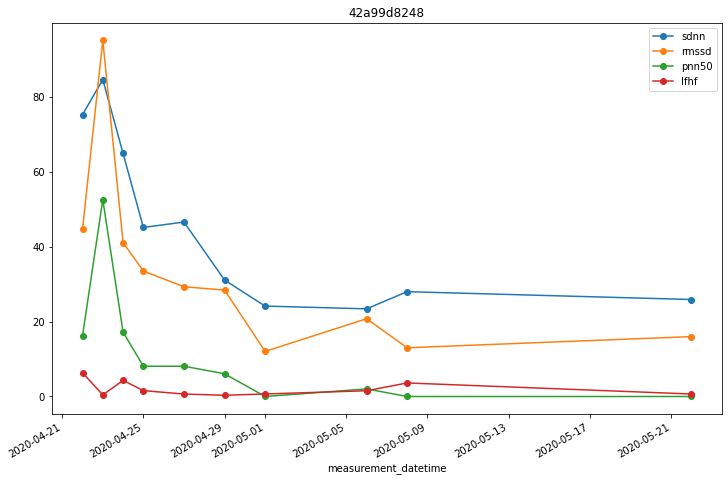

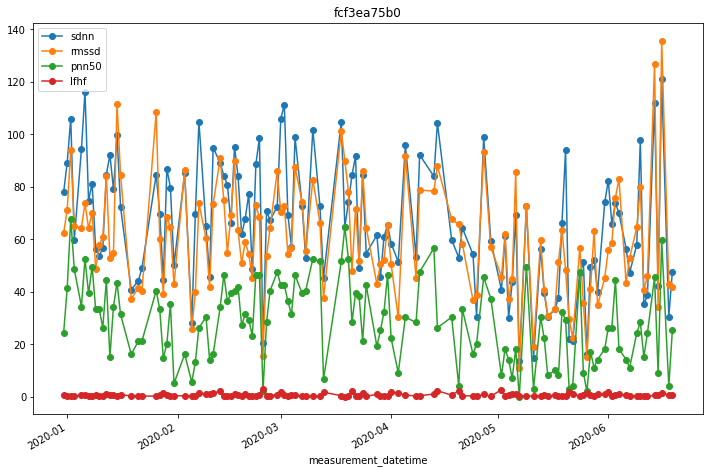

In [ ]:
# HRV Data (Colman)

df_hrv = dfs['hrv_measurements']

# print the columns to see what data does it have
#print(df_hrv.columns)

# let's look at the datetime column 
#print(df_hrv['measurement_datetime'].unique())

# We get a list of dates and use it as the x-axis of the time series (TODO: probably need a better way)
#dlist = pd.to_datetime(df_hrv['measurement_datetime']).dt.date
#dlist = pd.to_datetime(dlist).dt.normalize() # convert from object to datetime[ns]
#dlist = dlist.unique() # turns out only 172 days have measurements

# Note that the measurement is in date + time, but we are predicting the onset date only
# so we have to combine measurement of the same date into one

# get list of column names for new dataframes
#column_names = df_hrv.columns
#column_names = column_names.drop(labels=['user_code', 'measurement_datetime']) # remove unnecessary columns

# prepare to construct a dataframe for each participant (TODO: is there better approach for a 3D dataframe?)
df_hrv_pp = {}
# get list of participants
plist = df_hrv['user_code'].unique()

# start with an naive approach: we only get the first entry and drop the remaining ones
# (i.e., we take the first measurement of the day to represent the whole day)
# iterate participant
plist_used = []
for p in plist:
  # filter out measurements and drop NaN
  tmp = df_hrv.loc[df_hrv['user_code'] == p].copy().dropna()

  # TODO drop data if it does not fulfill requirement (e.g., less than 5 entries)
  if tmp.shape[0] < 3:
    continue
  
  # convert datetime to date only
  tmp['measurement_datetime'] = pd.to_datetime(tmp['measurement_datetime']).dt.date
  tmp['measurement_datetime'] = pd.to_datetime(tmp['measurement_datetime']).dt.normalize() # convert from object to datetime[ns]
  #tmp['measurement_datetime'] =  tmp['measurement_datetime'].dt.strftime('%Y-%m-%d')
  # drop user_code column
  tmp = tmp.drop(columns=['user_code', 'rr_code', 'time_of_day', 'how_feel', 'how_mood', 'how_sleep', 'rr_data', 'tags'])

  # set date time as key
  tmp.set_index('measurement_datetime', inplace=True)

  # check if datetime is unique
  if not tmp.index.is_unique:
    # calculate mean for duplicates
    tmp = tmp.reset_index().pivot_table(columns=["measurement_datetime"]).T

  # drop duplicates
  #tmp.drop_duplicates(keep='first')

  # set dataframe
  df_hrv_pp[p] = tmp
  plist_used.append(p)

print("Extracted: " + str(len(df_hrv_pp)) + " participants")

# let's randomly plot one participant
import random
user_code, df_hrv_random = random.choice(list(df_hrv_pp.items()))

#print(df_hrv_random)
df_hrv_random.plot(y=['sdnn','rmssd','pnn50','lfhf'], kind='line', marker='o', figsize=(12, 8), title=user_code)

# also, fcf3ea75b0 is interesting to look at
user_code = 'fcf3ea75b0'
df_hrv_pp[user_code].plot(y=['sdnn','rmssd','pnn50','lfhf'], kind='line', marker='o', figsize=(12, 8), title=user_code)

In [ ]:
# # assign 1 if user_code is in df_p, 0 if not
# old_df_sleep = old_df_sleep.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
# # only keep user_codes that were in df_p, drop extra column
# old_df_sleep = old_df_sleep[old_df_sleep.InDFP != 0].drop(columns=['InDFP'])

#temp_df_hrv = pd.DataFrame(df_hrv_pp)
sklearn_covid = df_covid.assign(InDF = df_covid.index.isin(df_hrv_pp.keys()).astype(int))
sklearn_covid = sklearn_covid[sklearn_covid.InDF != 0].drop(columns=['InDF'])
#print(sklearn_covid.shape)
covid_codes = sklearn_covid.index.tolist()
covid_dates = sklearn_covid.columns.tolist()

temp_df_hrv = df_hrv_pp.copy()
for key in df_hrv_pp.keys():
    if key not in sklearn_covid.index:
        del temp_df_hrv[key]

col_date = 'measurement_datetime'
dates = []
all_dates = []
for key in temp_df_hrv.keys():
    these_dates = temp_df_hrv[key].index.tolist()
    for date in these_dates:
        if date not in dates and date in covid_dates:
            dates.append(date)
# print(dates)
for i in range(len(dates)):
    dates[i] = dates[i].to_pydatetime()
    dates[i] = dates[i].strftime("%Y-%m-%d")
# print(dates)
# print(len(temp_df_hrv.keys()), len(dates))
# print(temp_df_hrv[covid_codes[0]])
# print(temp_df_hrv[covid_codes[0]].loc[dates[0]]['amo'])

combo_index = []
for code in covid_codes:
    for date in dates:
        combo_index.append(code + "_" + str(date))

full_hrv_dict = {}
full_covid_dict = {}
hrv_columns = temp_df_hrv[covid_codes[0]].columns.tolist()
for col in hrv_columns:
    full_hrv_dict[col] = []
full_hrv_dict['covid'] = []

errors = 0
for code in covid_codes:
    for date in dates:
        for col in hrv_columns:
            try:
                full_hrv_dict[col].append(temp_df_hrv[code].loc[date][col])
            except:
                full_hrv_dict[col].append(0.0)
        full_hrv_dict['covid'].append(int(sklearn_covid.loc[code][date]))
        
sklearn_hrv = pd.DataFrame(full_hrv_dict, index=combo_index)
# test_clf = LogisticRegression(random_state=0).fit(df_covid, df_hrv_pp)

## Sleep

In [ ]:
# Sleep data (Hunter)
# 1. Bring in sleep data
# 2. Filter by patient ID and dates
# 3. Prepare dataframe for LR or other ML model

#print(df_covid)

old_df_sleep = dfs['sleep']
# drop columns that aren't filled for all users
old_df_sleep = old_df_sleep.drop(columns=['sleep_awake_duration', 'sleep_rem_duration', 'sleep_light_duration', 'sleep_deep_duration'])
old_df_sleep = old_df_sleep.drop(columns=['pulse_min', 'pulse_max', 'pulse_average'])
old_df_sleep = old_df_sleep.drop(columns=['sleep_begin', 'sleep_end'])
# assign 1 if user_code is in df_p, 0 if not
old_df_sleep = old_df_sleep.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
# only keep user_codes that were in df_p, drop extra column
old_df_sleep = old_df_sleep[old_df_sleep.InDFP != 0].drop(columns=['InDFP'])
# print(old_df_sleep)

sleep_columns = list(old_df_sleep.day.unique())
sleep_index = list(old_df_sleep.user_code.unique())    
user_dict = {}
for code in sleep_index:
    user_dict[code] = {}

sleep_user_code = old_df_sleep.user_code.tolist()
sleep_day = old_df_sleep.day.tolist()
sleep_duration = old_df_sleep.sleep_duration.tolist()

for i in range(0, len(sleep_user_code)):
    user_dict[sleep_user_code[i]][sleep_day[i]] = sleep_duration[i]

#print(user_dict)

sleep_dict = {}
for date in sleep_columns:
     sleep_dict[date] = []
     for code in sleep_index:
         if date not in user_dict[code].keys():
             sleep_dict[date].append(0)
         else:
             sleep_dict[date].append(user_dict[code][date])

df_sleep = pd.DataFrame(sleep_dict, index = sleep_index)

print(df_sleep)

            2020-01-21  2020-01-30  2020-01-31  2020-02-02  2020-02-03  \
276ab22485      9543.0         0.0         0.0         0.0         0.0   
4985083f4d         0.0     29265.0     24771.0     11410.0     31705.0   
6be5033971     29400.0     29700.0     35100.0     30300.0     35700.0   
9871ee5e7b         0.0         0.0         0.0         0.0         0.0   
a1c2e6b2eb         0.0         0.0         0.0         0.0         0.0   
c174f32d88         0.0         0.0         0.0         0.0         0.0   
fcf3ea75b0         0.0         0.0         0.0         0.0         0.0   

            2020-02-05  2020-02-09  2020-02-12  2020-02-13  2020-02-14  ...  \
276ab22485         0.0         0.0         0.0         0.0         0.0  ...   
4985083f4d     24492.0     14522.0      5130.0      5235.0     29883.0  ...   
6be5033971     35700.0     33300.0     36600.0     36300.0     33300.0  ...   
9871ee5e7b         0.0         0.0         0.0         0.0         0.0  ...   
a1c2e6b2eb  

## Wearables

In [ ]:
#Wearable Data 
#TODO:
# 1 : Load in wearable data
# 2 : Filter by patient ID and dates
# 3 : Prepare dataframe for LR or other ML model

df_wearable = dfs['wearables'].copy()

#drop columns that aren't filled for most users
#adjust if necessary later
df_wearable =  df_wearable.drop(columns=['resting_pulse', 'average_spo2_value','body_temperature_avg', 'stand_hours_total','distance','total_number_of_flights_climbed','active_calories_burned','average_headphone_exposure','average_environment_exposure'])
# assign 1 if user_code is in df_p, 0 if not
df_wearable = df_wearable.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
df_wearable = df_wearable[df_wearable['user_code'].notna()]

# only keep user_codes that were in df_p, drop extra column
df_wearable = df_wearable[df_wearable.InDFP != 0].drop(columns=['InDFP'])

#remove user codes which are NaN
#Note: Check why this happened
#df_wearable = df_wearable[df_wearable['user_code'].notna()]

df_wearable = df_wearable[df_wearable['user_code'].notna()]
df_wearable['date'] = df_wearable.apply(lambda _: '', axis=1)
df_wearable_cp= df_wearable.copy()
df_wearable_cp = df_wearable_cp.dropna()
# df_wearable_cp2= df_wearable.copy()

df_wearable_pp = {}
plist = df_wearable_cp['user_code'].unique()
for p in plist:
  # filter out measurements and drop NaN
  tmp = df_wearable_cp.loc[df_wearable_cp['user_code'] == p].copy().dropna()

  # TODO drop data if it does not fulfill requirement (e.g., less than 5 entries)
  if tmp.shape[0] < 3:
    continue
  
  # convert datetime to date only
  tmp['day'] = pd.to_datetime(tmp['day']).dt.date
  tmp['day'] = pd.to_datetime(tmp['day']).dt.normalize() # convert from object to datetime[ns]
  #tmp['measurement_datetime'] =  tmp['measurement_datetime'].dt.strftime('%Y-%m-%d')
  # drop user_code column
  tmp = tmp.drop(columns=['user_code'])

  # set date time as key
  tmp.set_index('day', inplace=True)

  # check if datetime is unique
  if not tmp.index.is_unique:
    # calculate mean for duplicates
    tmp = tmp.reset_index().pivot_table(columns=["day"]).T

  # drop duplicates
  #tmp.drop_duplicates(keep='first')

  # set dataframe
  df_wearable_pp[p] = tmp
  plist_used.append(p)

temp_df_wearables = df_wearable_pp.copy()

# print(df_wearable_pp)

# wearable_columns = list(df_wearable.day.unique())
# wearable_index = list(df_wearable.user_code.unique())    
# user_dict = {}
# for code in wearable_index:
#     user_dict[code] = {}

# wearable_user_code = df_wearable.user_code.tolist()
# wearable_day = df_wearable.day.tolist()
# wearable_duration = df_wearable.sleep_duration.tolist()
# print(df_wearable_cp.columns)
# print(df_wearable.iloc[0][1])

#Filter Dates 
# for i, r in enumerate(df_wearable['day']):
#     str_list = r.split("-")
#     for j in range(0, len(str_list)):
#         if str_list[j][0] == '0':
#             str_list[j] = str_list[j][1:]
#     new_str_list = [str_list[1], str_list[2], str_list[0]]
#     df_wearable.loc[i, 'day'] = '/'.join(new_str_list)

# df_wearable_mapping = df_wearable.assign(StartDate = df_wearable.day.isin(df_p.symptoms_onset).astype(int))
# df_wearable_mapping = df_wearable_mapping.dropna()

# print(df_wearable_mapping)
# print(len(list(df_wearable_mapping.user_code.unique())))

df_wearable_cp['combo_index'] = df_wearable_cp['user_code'].str.cat(df_wearable_cp['day'], sep = "_")
# df_wearable_cp = df_wearable_cp.drop(columns=['user_code', 'day'])
# df_wearable_cp = df_wearable_cp.set_index('combo_index')
# print(df_wearable_cp.shape)

In [ ]:
# ['user_code', 'day', 'pulse_average', 'pulse_min', 'pulse_max',
#        'steps_count', 'steps_speed', 'basal_calories_burned',
#        'total_calories_burned', 'date']
print(df_wearable_cp.shape)
wearable_index = df_wearable_cp.index.tolist()
bad_wearable_index_i = []
for i in wearable_index:
    if df_wearable_cp['combo_index'][i] not in combo_index:
        bad_wearable_index_i.append(i)

sklearn_wearable = df_wearable_cp.drop(labels=bad_wearable_index_i, axis=0)
sklearn_wearable = sklearn_wearable.set_index('combo_index')
sklearn_wearable['covid'] = ""

for index in sklearn_wearable.index:
    if sklearn_wearable.loc[index][0] in sklearn_covid.index and sklearn_wearable.loc[index][1] in dates:
        sklearn_wearable.at[index, 'covid'] = int(sklearn_covid.loc[sklearn_wearable.loc[index][0]][sklearn_wearable.loc[index][1]])
sklearn_wearable_input = sklearn_wearable 
sklearn_wearable = sklearn_wearable.drop(columns=['user_code', 'day'])
sklearn_wearable = sklearn_wearable.apply(pd.to_numeric)
sklearn_wearable = sklearn_wearable.drop(columns=['date'])
print(sklearn_wearable.shape)
# print(sklearn_wearable.head())

(910, 11)
(305, 8)


# Dataset Analysis

Text(0.5, 1.0, 'Mapped')

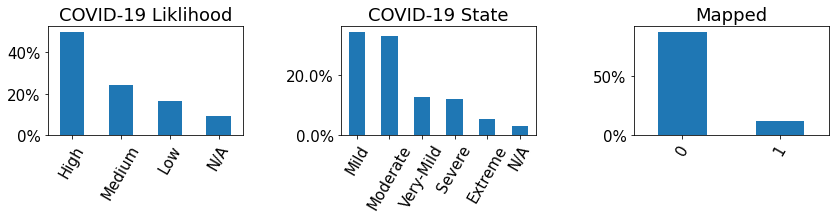

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 15})

df = dfs['surveys']
df1 = df[(df['scale'] == 'S_CORONA')]
df2 = df[(df['scale'] == 'S_COVID_OVERALL')]

fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.5)
fig.set_figheight(2)
fig.set_figwidth(14)

vc1 = df1['text'].value_counts()
vc1 = 100*vc1/len(df1)
vc1.index = ['High', 'Medium', 'Low', 'N/A']
ax1 = vc1.plot(kind = 'bar', ax=axs[0])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title('COVID-19 Liklihood')

vc2 = df2['text'].value_counts()
vc2 = 100*vc2/len(df2)
vc2.index = ['Mild', 'Moderate', 'Very-Mild', 'Severe', 'Extreme', 'N/A']
ax2 = vc2.plot(kind = 'bar', ax=axs[1])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_title('COVID-19 State')

vc3 = np.sum(df_covid.apply(pd.value_counts), axis=1)
vc3 = 100*vc3/sum(vc3)
ax3 = vc3.plot(kind='bar', ax=axs[2])
# ax3.index = ['Negative', 'Positive']
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=60)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_title('Mapped')

In [ ]:
# Participant Stats
print('N_participants =', len(np.unique(dfs['participants']['user_code'])))
print()

# Pre-processing Stats
print('N_hrv =', len(np.unique(dfs['hrv_measurements']['user_code'])))
print('N_sleep =', len(np.unique(dfs['sleep']['user_code'])))
print('N_wearables =', len(np.unique(dfs['wearables']['user_code'])))
print('N_covid =', len(np.unique(dfs['surveys']['user_code'])))
print()

# Processed Stats
print('N_hrv_pp =', len(df_hrv_pp))
print('N_covid_pp =', len(df_covid.index.unique()))
print('N_sleep_pp =', len(df_sleep.index.unique()))
print('N_wearable_pp =', len(df_wearable_cp['user_code'].unique()))
print()

# Time stats
print('T_span =', np.max(df_covid.columns)-np.min(df_covid.columns))
print()

# Training/testing stats
print('N_covid+hrv =', len(np.intersect1d(df_covid.index, 
                                          plist_used)))
print('N_covid+wearables =', len(np.intersect1d(df_covid.index, 
                                                df_wearable_cp['user_code'].unique())))
print('N_covid+wearables+hrv =', len(np.intersect1d(np.intersect1d(df_covid.index, plist_used), 
                                                    df_wearable_cp['user_code'].unique())))
print()

N_participants = 185

N_hrv = 185
N_sleep = 10
N_wearables = 79
N_covid = 111

N_hrv_pp = 60
N_covid_pp = 100
N_sleep_pp = 7
N_wearable_pp = 32

T_span = 56 days 00:00:00

N_covid+hrv = 50
N_covid+wearables = 26
N_covid+wearables+hrv = 26



# Classification

In [ ]:
df

,user_code,scale,created_at,value,text
0,01bad5a519,S_CORONA,2020-04-23,2,Symptoms are characteristic of coronavirus
1,01bad5a519,S_COVID_BLUISH,2020-04-23,1,User isn’t experiencing symptom
2,01bad5a519,S_COVID_BLUISH,2020-04-25,1,User isn’t experiencing symptom
3,01bad5a519,S_COVID_BLUISH,2020-04-27,1,User isn’t experiencing symptom
4,01bad5a519,S_COVID_BLUISH,2020-04-29,1,User isn’t experiencing symptom
...,...,...,...,...,...
2254,fe6c1b1349,S_COVID_FATIGUE,2020-05-12,4,Moderate
2255,fe6c1b1349,S_COVID_FEVER,2020-05-12,4,Moderate
2256,fe6c1b1349,S_COVID_OVERALL,2020-05-12,3,Mild
2257,fe6c1b1349,S_COVID_PAIN,2020-05-12,1,User isn’t experiencing symptom


## HRV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sklearn_hrv.drop(["covid"], axis=1), sklearn_hrv["covid"], test_size=1/4, random_state=42)

lr_hrv = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
lr_score = lr_hrv.score(X_test, y_test) # Return the mean accuracy on the given test data and labels.
print("Logistic Regression: " + str(lr_score))

mlpc_hrv = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
mlpc_score = mlpc_hrv.score(X_test, y_test)
print("MultiLayer Perceptron: " + str(mlpc_score))

# SVMs are SLOW but they eventually complete lol
linsvc_hrv = LinearSVC(random_state=42).fit(X_train, y_train)
linsvc_score = linsvc_hrv.score(X_test, y_test)
print("SVM-LinearSVC: " + str(linsvc_score))

nusvc_hrv = NuSVC(nu=0.2, random_state=42).fit(X_train, y_train)
nusvc_score = nusvc_hrv.score(X_test, y_test)
print("SVM-NuSVC: " + str(nusvc_score))

# svclin_hrv = SVC(kernel="linear", random_state=42).fit(X_train, y_train)
# svclin_score = svclin_hrv.score(X_test, y_test)
# print("SVM-SVC (linear kernel): " + str(svclin_score))

# svcrbf_hrv = SVC(kernel="rbf", random_state=42).fit(X_train, y_train)
# svcrbf_score = svcrbf_hrv.score(X_test, y_test)
# print("SVM-SVC (rbf kernel): " + str(svcrbf_score))

Logistic Regression: 0.8281853281853282
MultiLayer Perceptron: 0.805019305019305
SVM-LinearSVC: 0.8185328185328186
SVM-NuSVC: 0.8088803088803089


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## Wearables

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sklearn_wearable.drop(["covid"], axis=1), sklearn_wearable["covid"], test_size=1/4, random_state=42)

lr_w = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
lr_score = lr_w.score(X_test, y_test)
print("Logistic Regression: " + str(lr_score))

mlpc_w = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
mlpc_score = mlpc_w.score(X_test, y_test)
print("MultiLayer Perceptron: " + str(mlpc_score))

# SVMs are SLOW but they eventually complete lol
linsvc_w = LinearSVC(random_state=42).fit(X_train, y_train)
linsvc_score = linsvc_w.score(X_test, y_test)
print("SVM-LinearSVC: " + str(linsvc_score))

nusvc_w = NuSVC(random_state=42).fit(X_train, y_train)
nusvc_score = nusvc_w.score(X_test, y_test)
print("SVM-NuSVC: " + str(nusvc_score))

# svclin_w = SVC(kernel="linear", random_state=42).fit(X_train, y_train)
# svclin_score = svclin_w.score(X_test, y_test)
# print("SVM-SVC (linear kernel): " + str(svclin_score))

# svcrbf_w = SVC(kernel="rbf", random_state=42).fit(X_train, y_train)
# svcrbf_score = svcrbf_w.score(X_test, y_test)
# print("SVM-SVC (rbf kernel): " + str(svcrbf_score))

Logistic Regression: 0.6233766233766234
MultiLayer Perceptron: 0.5714285714285714
SVM-LinearSVC: 0.35064935064935066
SVM-NuSVC: 0.6233766233766234


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# RNN Testing

## Imports and Helpers

In [ ]:
%tensorflow_version 2.x
# !pip install tensorflow_addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution 
disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.
# The best value is 1 and the worst value is 0.
def recall(y_true, y_pred, threshold):
    # true positive / (true positive / false negative)
    tp = 0
    fn = 0
    for i in range(len(y_true)):
        # if y_true[i] == 1 and y_pred[i][0] >= threshold:
        #     tp += 1
        # elif y_true[i] == 0 and y_pred[i][0] >= threshold:
        #     fn += 1
        if y_true[i] - threshold <= y_pred[i][0] <= y_true[i] + threshold:
            tp += 1
        elif y_pred[i][0] < y_true[i] - threshold:
            fn += 1
    return tp / (tp + fn)

# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# The best value is 1 and the worst value is 0.
def precision(y_true, y_pred, threshold):
    # true positive / (true positive / false positive)
    tp = 0
    fp = 0
    for i in range(len(y_true)):
        # if y_true[i] == 1 and y_pred[i][0] >= threshold:
        #     tp += 1
        # elif y_true[i] == 0 and y_pred[i][0] >= threshold:
        #     fp += 1
        if y_true[i] - threshold <= y_pred[i][0] <= y_true[i] + threshold:
            tp += 1
        elif y_pred[i][0] > y_true[i] + threshold:
            fp += 1
    return tp / (tp + fp)

# The F1 score can be interpreted as a harmonic mean of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
def f1_score(y_true, y_pred, threshold):
    precision1 = precision(y_true, y_pred, threshold)
    recall1 = recall(y_true, y_pred, threshold)
    return 2*((precision1*recall1)/(precision1+recall1))

In [ ]:
def roc_curve(y_true, y_pred):
    thresholds = np.arange(0.0, 1.001, 0.001)
    classes = [0, 0.25, 0.5, 0.75, 1.0]

    full_fpr = []
    full_tpr = []
    for cls in classes:
        fpr = []
        tpr = []
        P = sum([1 for y in y_true if y == cls])
        N = len(y_true) - P
        for threshold in thresholds:
            tp=0
            fp=0
            threshold = round(threshold,10)
            for i in range(len(y_true)):
                if cls - threshold <= y_pred[i][0] <= cls + threshold:
                    if y_true[i] == cls:
                        tp += 1
                    else:
                        fp += 1
            fpr.append(fp/N)
            tpr.append(tp/P)
        full_fpr.append(fpr)
        full_tpr.append(tpr)
    return full_fpr, full_tpr

## HRV Dataset Redo

In [ ]:
min_length = 4

rnn_hrv_input = []
rnn_hrv_output = []

# max_list_length = []
# for key in temp_df_hrv.keys():
#     this_length = 0
#     hrv_dates = list(temp_df_hrv[key].index)
#     for date in hrv_dates:
#         if date in df_covid.columns:
#             this_length += 1
#     max_list_length.append(this_length)
# max_list_length = sorted(max_list_length)
# print(max_list_length)

for key in temp_df_hrv.keys():
    covid_hrv_np = []
    hrv_np = []
    hrv_dates = list(temp_df_hrv[key].index)
    for date in hrv_dates:
        if date in df_covid.columns:
            covid_hrv_np.append(df_covid.loc[key][date].astype('int'))
            hrv_np.append(list(temp_df_hrv[key].loc[date].to_numpy().astype('float')))
    # print(hrv_np)
    # print(covid_hrv_np)

    #if len(covid_hrv_np) >= min_length:
    #    if 1 in covid_hrv_np:
    #        covid_index = covid_hrv_np.index(1)
    #        if covid_index+1 > min_length:
    #            rnn_hrv_input.append(hrv_np[covid_index-(min_length-1):covid_index+1])
    #            # rnn_hrv_output.append(covid_hrv_np[covid_index-(min_length-1):covid_index+1])
    #        else:
    #            rnn_hrv_input.append(hrv_np[:min_length])
    #            # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(1)
    #    else:
    #        rnn_hrv_input.append(hrv_np[:min_length])
    #        # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(0)

    # sliding window
    if len(covid_hrv_np) >= min_length:
        for w in range(len(covid_hrv_np) - min_length + 1):
            if covid_hrv_np[w:w+min_length][-1] == 0 and covid_hrv_np[w:w+min_length][0] == 1:
                continue
            rnn_hrv_input.append(hrv_np[w:w+min_length])
            rnn_hrv_output.append(sum(covid_hrv_np[w:w+min_length])/min_length)
            # if 1 in covid_hrv_np[w:w+min_length]:
            #     rnn_hrv_output.append(1)
            # else:
            #     rnn_hrv_output.append(0)



In [ ]:
# checking hrv data
print("Number of entries: " + str(len(rnn_hrv_input)))

pos = sum(rnn_hrv_output)

print("Positive: " + str(pos/len(rnn_hrv_output)) + " Negative: " + str(1-pos/len(rnn_hrv_output)))
#total_output = sum( [ len(c) for c in rnn_hrv_output])
print(rnn_hrv_input)

Number of entries: 215
Positive: 0.513953488372093 Negative: 0.486046511627907
[[[44.0, 69.0, 87.0, 75.0, 0.862, 867.22, 0.875, 0.11, 4.04, 21.894, 31.382, 435.0, 273.0], [69.0, 94.0, 100.0, 117.0, 1.17, 636.67, 0.625, 0.11, 3.03, 18.245, 24.956, 255.0, 38.0], [82.0, 72.0, 31.0, 54.0, 1.742, 832.69, 0.825, 0.06, 0.0, 11.97, 16.141, 141.0, 56.0], [78.5, 88.5, 86.0, 119.5, 1.2025000000000001, 678.575, 0.675, 0.085, 5.555, 24.3795, 22.664, 241.5, 36.0]], [[69.0, 94.0, 100.0, 117.0, 1.17, 636.67, 0.625, 0.11, 3.03, 18.245, 24.956, 255.0, 38.0], [82.0, 72.0, 31.0, 54.0, 1.742, 832.69, 0.825, 0.06, 0.0, 11.97, 16.141, 141.0, 56.0], [78.5, 88.5, 86.0, 119.5, 1.2025000000000001, 678.575, 0.675, 0.085, 5.555, 24.3795, 22.664, 241.5, 36.0], [62.0, 101.0, 36.0, 123.0, 3.417, 594.38, 0.575, 0.05, 0.0, 10.89, 14.737, 165.0, 6.0]], [[44.0, 86.66666666666667, 2398.6666666666665, 929.0, 0.5553333333333333, 696.8766666666667, 0.7083333333333334, 0.19666666666666666, 20.873333333333335, 73.6163333333333

## HRV RNN

In [ ]:
# INPUTS
#cut_index = 4
# cut_index = int(len(rnn_hrv_input) * 0.4) # get more testing samples
cut_index = int(len(rnn_hrv_input) * 0.2) # testing = 20% of our inputs

# shuffle dataset
indices = tf.range(start=0, limit=len(rnn_hrv_input), dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed=57344, name="hrv_indices")
tf.print(shuffled_indices)

shuffled_rnn_hrv_input = tf.gather(rnn_hrv_input, shuffled_indices)
shuffled_rnn_hrv_output = tf.gather(rnn_hrv_output, shuffled_indices)

tmp_input_hrv_train = tf.convert_to_tensor(shuffled_rnn_hrv_input[cut_index:], dtype=tf.float32)
tmp_input_hrv_val = tf.convert_to_tensor(shuffled_rnn_hrv_input[:cut_index], dtype=tf.float32)

input_hrv_train = layers.Input(shape=tmp_input_hrv_train.shape,
                               tensor=tmp_input_hrv_train)
input_hrv_val = layers.Input(shape=tmp_input_hrv_val.shape,
                             tensor=tmp_input_hrv_val)

output_hrv_train = tf.convert_to_tensor(shuffled_rnn_hrv_output[cut_index:], dtype=tf.float32)
output_hrv_val = tf.convert_to_tensor(shuffled_rnn_hrv_output[:cut_index], dtype=tf.float32)

print(input_hrv_train.shape, output_hrv_train.shape)
print(input_hrv_val.shape, output_hrv_val.shape)
# print(input_hrv_test.shape, output_hrv_test.shape)

tmp_input_hrv_tests = []
input_hrv_tests = []
output_hrv_tests = []
for i in range(0, cut_index):
    tmp_input_hrv_tests.append(tf.convert_to_tensor([shuffled_rnn_hrv_input[i]], dtype=tf.float32))
    input_hrv_tests.append(layers.Input(shape=tmp_input_hrv_tests[i].shape,
                                tensor=tmp_input_hrv_tests[i]))
    output_hrv_tests.append(tf.convert_to_tensor([shuffled_rnn_hrv_output[i]], dtype=tf.float32))

(172, 4, 13) (172,)
(43, 4, 13) (43,)


In [ ]:
# Adding callbacks (save checkpoint and early stopping)
CHECKPOINT_PATH = '/tmp/checkpoint'


In [ ]:
# MODEL
num_loops = 1

for i in range(num_loops):
    training_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    ]

    model = keras.Sequential()

    # LSTM Layer
    # model.add(layers.LSTM(input_hrv_val.shape[1], input_shape=input_hrv_val.shape[1:]))
    model.add(layers.SimpleRNN(input_hrv_val.shape[1]*16, 
                            input_shape=input_hrv_val.shape[1:], 
                            recurrent_regularizer=keras.regularizers.L2(0.1), 
                            activation='tanh'))
    # Dense Layer
    # kernel_regularizer=keras.regularizers.L2(0.01), 
    model.add(layers.Dense(input_hrv_val.shape[1]*8,
                        kernel_regularizer=keras.regularizers.L2(0.05), 
                        activation='tanh'))
    model.add(layers.Dense(input_hrv_val.shape[1]*2,
                           activation='tanh'))
    model.add(layers.Dense(int(input_hrv_val.shape[1]),
                        activation='tanh'))
    # model.add(layers.Dense(input_hrv_val.shape[1]*8, activation='tanh'))
    # if many-to-many, comment out this layer
    # Dense layer size 1 for BCE
    model.add(layers.Dense(1, activation='tanh'))

    # Binary Cross Entropy
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                optimizer=tf.optimizers.SGD(),
                metrics=["accuracy", keras.metrics.AUC()])

    # Fit the model
    history = model.fit(input_hrv_train, output_hrv_train,
                        batch_size=1,
                        steps_per_epoch=input_hrv_train.shape[0],
                        epochs=300,
                        validation_data=(input_hrv_val, output_hrv_val),
                        validation_steps=input_hrv_val.shape[0],#)
                        callbacks = training_callbacks) # colman: added callbacks for early stopping and saving best checkpoint (maximizing accuracy)

Train on 172 samples, validate on 43 samples
Epoch 1/300
172/172 [==============================] - 2s 6ms/step - batch: 85.5000 - size: 1.0000 - loss: 6.7804 - accuracy: 0.6254 - auc: 0.7084 - val_loss: 5.0347 - val_accuracy: 0.6539 - val_auc: 0.7516
Epoch 2/300
172/172 [==============================] - 1s 4ms/step - batch: 85.5000 - size: 1.0000 - loss: 3.9041 - accuracy: 0.6814 - auc: 0.7724 - val_loss: 2.9734 - val_accuracy: 0.7020 - val_auc: 0.7829
Epoch 3/300
172/172 [==============================] - 1s 4ms/step - batch: 85.5000 - size: 1.0000 - loss: 2.3630 - accuracy: 0.7022 - auc: 0.7963 - val_loss: 1.8583 - val_accuracy: 0.7031 - val_auc: 0.7935
Epoch 4/300
172/172 [==============================] - 1s 4ms/step - batch: 85.5000 - size: 1.0000 - loss: 1.5163 - accuracy: 0.7090 - auc: 0.8064 - val_loss: 1.2373 - val_accuracy: 0.7090 - val_auc: 0.8287
Epoch 5/300
172/172 [==============================] - 1s 7ms/step - batch: 85.5000 - size: 1.0000 - loss: 1.0443 - accuracy: 0

In [ ]:
# Validation set loss & accuracy
results = model.evaluate(input_hrv_val, output_hrv_val, steps=input_hrv_val.shape[0])
print("validation loss, acc, auc: ", results)

# # Predict COVID in a witheld sample from the training set
for i in range(0, cut_index):
    prediction = model.predict(input_hrv_tests[i], output_hrv_tests[i], steps=1)
    print(i, " test actual, prediction: ", rnn_hrv_output[i], prediction[0])
    # print(i, " test prediction: ", prediction)

prediction = model.predict(input_hrv_val, output_hrv_val, steps=1)
# print(rnn_hrv_output[:cut_index], prediction)
print("precision: ", precision(rnn_hrv_output[:cut_index], prediction, 0.125))
print("recall: ", recall(rnn_hrv_output[:cut_index], prediction, 0.125))
print("f1 score: ", f1_score(rnn_hrv_output[:cut_index], prediction, 0.125))

print(model.summary())

validation loss, acc, auc:  [0.23576700756716173, 0.7349919, 0.8507104]
0  test actual, prediction:  0.75 [0.05415584]
1  test actual, prediction:  1.0 [0.7928586]
2  test actual, prediction:  0.25 [0.00226008]
3  test actual, prediction:  0.0 [0.03835226]
4  test actual, prediction:  0.0 [0.05415584]
5  test actual, prediction:  0.0 [0.00239288]
6  test actual, prediction:  0.0 [0.01662792]
7  test actual, prediction:  1.0 [-0.01478671]
8  test actual, prediction:  1.0 [0.07130896]
9  test actual, prediction:  1.0 [0.69761884]
10  test actual, prediction:  1.0 [0.98390496]
11  test actual, prediction:  1.0 [0.04115556]
12  test actual, prediction:  1.0 [0.2615081]
13  test actual, prediction:  1.0 [0.01662792]
14  test actual, prediction:  1.0 [0.40632954]
15  test actual, prediction:  1.0 [0.5686112]
16  test actual, prediction:  1.0 [0.00377296]
17  test actual, prediction:  0.0 [0.0055607]
18  test actual, prediction:  0.0 [0.00480684]
19  test actual, prediction:  0.0 [0.0055607]


In [ ]:
# print result using best model
# Loads the weights
model.load_weights(CHECKPOINT_PATH)

# Validation set loss & accuracy
results = model.evaluate(input_hrv_val, output_hrv_val, steps=input_hrv_val.shape[0])
print("validation loss, acc: ", results)

# # Predict COVID in a witheld sample from the training set
for i in range(0, cut_index):
    prediction = model.predict(input_hrv_tests[i], output_hrv_tests[i], steps=1)
    print(i, " test actual, prediction: ", rnn_hrv_output[i], prediction[0])
    # print(i, " test prediction: ", prediction)

prediction = model.predict(input_hrv_val, output_hrv_val, steps=1)
# print(rnn_hrv_output[:cut_index], prediction)
print("f1 score: ", f1_score(rnn_hrv_output[:cut_index], prediction, 0.125))


validation loss, acc:  [0.2031002543693365, 0.7625744, 0.8496765]
0  test actual, prediction:  0.75 [-0.02301191]
1  test actual, prediction:  1.0 [0.9930485]
2  test actual, prediction:  0.25 [0.99604124]
3  test actual, prediction:  0.0 [0.20604186]
4  test actual, prediction:  0.0 [-0.01686032]
5  test actual, prediction:  0.0 [-0.04408873]
6  test actual, prediction:  0.0 [0.98865366]
7  test actual, prediction:  1.0 [0.04081639]
8  test actual, prediction:  1.0 [0.20604186]
9  test actual, prediction:  1.0 [-0.13837352]
10  test actual, prediction:  1.0 [0.00765321]
11  test actual, prediction:  1.0 [0.9995754]
12  test actual, prediction:  1.0 [0.99900246]
13  test actual, prediction:  1.0 [-0.13903818]
14  test actual, prediction:  1.0 [0.99864966]
15  test actual, prediction:  1.0 [-0.04408896]
16  test actual, prediction:  1.0 [0.9974758]
17  test actual, prediction:  0.0 [0.99905545]
18  test actual, prediction:  0.0 [0.02652928]
19  test actual, prediction:  0.0 [0.99940896]

In [ ]:
full_fpr, full_tpr = roc_curve(rnn_hrv_output[:cut_index], prediction)

No handles with labels found to put in legend.


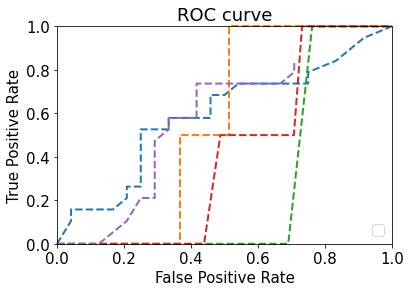

In [ ]:
for i in range(len(full_fpr)):
    plt.plot(full_fpr[i], full_tpr[i], linestyle='--', lw = 2, clip_on=False)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('AUC_example.png')
plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


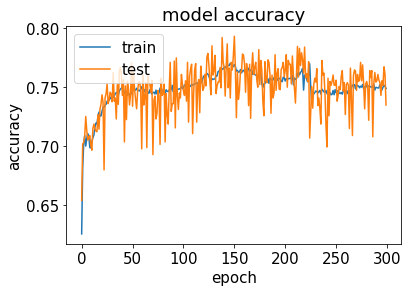

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

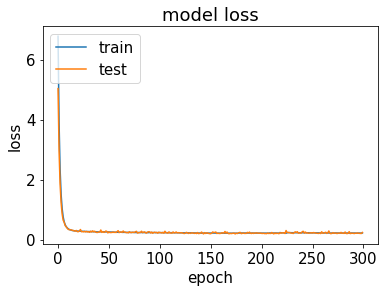

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

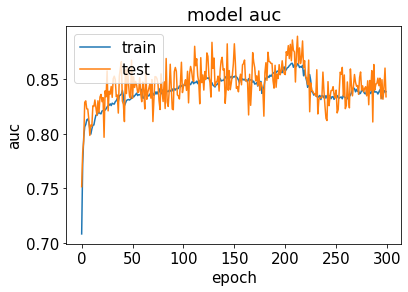

In [ ]:
plt.plot(history.history[list(history.history.keys())[2]])
plt.plot(history.history[list(history.history.keys())[5]])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Wearables Dataset Redo

In [ ]:
min_length = 4

rnn_wearables_input = []
rnn_wearables_output = []

# max_list_length = []
# for key in temp_df_hrv.keys():
#     this_length = 0
#     hrv_dates = list(temp_df_hrv[key].index)
#     for date in hrv_dates:
#         if date in df_covid.columns:
#             this_length += 1
#     max_list_length.append(this_length)
# max_list_length = sorted(max_list_length)
# print(max_list_length)

for key in temp_df_wearables.keys():
    covid_wearables_np = []
    wearables_np = []
    wearables_dates = list(temp_df_wearables[key].index)
    for date in wearables_dates:
        if date in df_covid.columns and key in df_covid.index:
            covid_wearables_np.append(df_covid.loc[key][date].astype('int'))
            # print(list(temp_df_wearables[key].loc[date].to_numpy()[:-1]))
            wearables_np.append(list(temp_df_wearables[key].loc[date].to_numpy()[:-1].astype('float')))
    # print(hrv_np)
    # print(covid_hrv_np)

    #if len(covid_hrv_np) >= min_length:
    #    if 1 in covid_hrv_np:
    #        covid_index = covid_hrv_np.index(1)
    #        if covid_index+1 > min_length:
    #            rnn_hrv_input.append(hrv_np[covid_index-(min_length-1):covid_index+1])
    #            # rnn_hrv_output.append(covid_hrv_np[covid_index-(min_length-1):covid_index+1])
    #        else:
    #            rnn_hrv_input.append(hrv_np[:min_length])
    #            # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(1)
    #    else:
    #        rnn_hrv_input.append(hrv_np[:min_length])
    #        # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(0)

    # sliding window
    if len(covid_wearables_np) >= min_length:
        for w in range(len(covid_wearables_np) - min_length + 1):
            if covid_wearables_np[w:w+min_length][-1] == 0 and covid_wearables_np[w:w+min_length][0] == 1:
                continue
            rnn_wearables_input.append(wearables_np[w:w+min_length])
            rnn_wearables_output.append(sum(covid_wearables_np[w:w+min_length])/min_length)
            # if 1 in covid_hrv_np[w:w+min_length]:
            #     rnn_hrv_output.append(1)
            # else:
            #     rnn_hrv_output.append(0)

In [ ]:
# checking wearables data
print("Number of entries: " + str(len(rnn_wearables_input)))

pos = sum(rnn_wearables_output)

print("Positive: " + str(pos/len(rnn_wearables_output)) + " Negative: " + str(1-pos/len(rnn_wearables_output)))
#total_output = sum( [ len(c) for c in rnn_hrv_output])
# print(rnn_wearables_input)

Number of entries: 251
Positive: 0.3605577689243028 Negative: 0.6394422310756972


## Wearables RNN

In [ ]:
# INPUTS
#cut_index = 4
# cut_index = int(len(rnn_hrv_input) * 0.4) # get more testing samples
cut_index_w = int(len(rnn_wearables_input) * 0.2) # testing = 20% of our inputs

# shuffle dataset
indices = tf.range(start=0, limit=len(rnn_wearables_input), dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed=57344, name="wearables_indices")
tf.print(shuffled_indices)

shuffled_rnn_wearables_input = tf.gather(rnn_wearables_input, shuffled_indices)
shuffled_rnn_wearables_output = tf.gather(rnn_wearables_output, shuffled_indices)

tmp_input_wearables_train = tf.convert_to_tensor(shuffled_rnn_wearables_input[cut_index_w:], dtype=tf.float32)
tmp_input_wearables_val = tf.convert_to_tensor(shuffled_rnn_wearables_input[:cut_index_w], dtype=tf.float32)

input_wearables_train = layers.Input(shape=tmp_input_wearables_train.shape,
                               tensor=tmp_input_wearables_train)
input_wearables_val = layers.Input(shape=tmp_input_wearables_val.shape,
                             tensor=tmp_input_wearables_val)

output_wearables_train = tf.convert_to_tensor(shuffled_rnn_wearables_output[cut_index_w:], dtype=tf.float32)
output_wearables_val = tf.convert_to_tensor(shuffled_rnn_wearables_output[:cut_index_w], dtype=tf.float32)

print(input_wearables_train.shape, output_wearables_train.shape)
print(input_wearables_val.shape, output_wearables_val.shape)
# print(input_wearables_test.shape, output_wearables_test.shape)

tmp_input_wearables_tests = []
input_wearables_tests = []
output_wearables_tests = []
for i in range(0, cut_index_w):
    tmp_input_wearables_tests.append(tf.convert_to_tensor([shuffled_rnn_wearables_input[i]], dtype=tf.float32))
    input_wearables_tests.append(layers.Input(shape=tmp_input_wearables_tests[i].shape,
                                tensor=tmp_input_wearables_tests[i]))
    output_wearables_tests.append(tf.convert_to_tensor([shuffled_rnn_wearables_output[i]], dtype=tf.float32))

(201, 4, 7) (201,)
(50, 4, 7) (50,)


In [ ]:
# Adding callbacks (save checkpoint and early stopping)
CHECKPOINT_PATH_W = '/tmp/checkpoint'


In [ ]:
# MODEL
num_loops = 1

for i in range(num_loops):
    training_callbacks_w = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH_W,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    ]

    model_w = keras.Sequential()

    # LSTM Layer
    # model_w.add(layers.LSTM(input_hrv_val.shape[1], input_shape=input_hrv_val.shape[1:]))
    model_w.add(layers.SimpleRNN(input_wearables_val.shape[1]*16, 
                            input_shape=input_wearables_val.shape[1:], 
                            recurrent_regularizer=keras.regularizers.L2(0.1), 
                            activation='tanh'))
    # Dense Layer
    # kernel_regularizer=keras.regularizers.L2(0.01), 
    model_w.add(layers.Dense(input_wearables_val.shape[1]*8,
                        kernel_regularizer=keras.regularizers.L2(0.05), 
                        activation='tanh'))
    model_w.add(layers.Dense(input_wearables_val.shape[1]*2, 
                           activation='tanh'))
    model_w.add(layers.Dense(input_wearables_val.shape[1],
                        activation='tanh'))
    # model_w.add(layers.Dense(input_hrv_val.shape[1]*8, activation='tanh'))
    # if many-to-many, comment out this layer
    # Dense layer size 1 for BCE
    model_w.add(layers.Dense(1, activation='tanh'))

    # Binary Cross Entropy
    model_w.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                optimizer=tf.optimizers.SGD(),
                metrics=["accuracy", keras.metrics.AUC()])

    # Fit the model_w
    history_w = model_w.fit(input_wearables_train, output_wearables_train,
                        batch_size=1,
                        steps_per_epoch=input_wearables_train.shape[0],
                        epochs=300,
                        validation_data=(input_wearables_val, output_wearables_val),
                        validation_steps=input_wearables_val.shape[0],
                        callbacks = training_callbacks_w)

    # Validation set loss & accuracy
    results = model_w.evaluate(input_wearables_val, output_wearables_val, steps=input_wearables_val.shape[0])
    print("validation loss, acc: ", results)

    # # Predict COVID in a witheld sample from the training set
    for i in range(0, cut_index_w):
        prediction = model_w.predict(input_wearables_tests[i], output_wearables_tests[i], steps=1)
        print(i, " test actual, prediction: ", rnn_wearables_output[i], prediction[0])
        # print(i, " test prediction: ", prediction)

    prediction = model_w.predict(input_wearables_val, output_wearables_val, steps=1)
    # print(rnn_hrv_output[:cut_index_w], prediction)
    print("f1 score: ", f1_score(rnn_wearables_output[:cut_index_w], prediction, 0.125))

    print(model_w.summary())

Train on 201 samples, validate on 50 samples
Epoch 1/300
201/201 [==============================] - 2s 7ms/step - batch: 100.0000 - size: 1.0000 - loss: 6.5147 - accuracy: 0.5806 - auc_1: 0.5847 - val_loss: 4.6372 - val_accuracy: 0.5800 - val_auc_1: 0.6286
Epoch 2/300
201/201 [==============================] - 1s 5ms/step - batch: 100.0000 - size: 1.0000 - loss: 3.4849 - accuracy: 0.5820 - auc_1: 0.6308 - val_loss: 2.5784 - val_accuracy: 0.5784 - val_auc_1: 0.6534
Epoch 3/300
201/201 [==============================] - 1s 4ms/step - batch: 100.0000 - size: 1.0000 - loss: 2.0035 - accuracy: 0.5864 - auc_1: 0.6424 - val_loss: 1.5413 - val_accuracy: 0.6112 - val_auc_1: 0.6712
Epoch 4/300
201/201 [==============================] - 1s 5ms/step - batch: 100.0000 - size: 1.0000 - loss: 1.2582 - accuracy: 0.6066 - auc_1: 0.6408 - val_loss: 1.0204 - val_accuracy: 0.6084 - val_auc_1: 0.6550
Epoch 5/300
201/201 [==============================] - 1s 4ms/step - batch: 100.0000 - size: 1.0000 - loss:

In [ ]:
# print result using best model
# Loads the weights
model_w.load_weights(CHECKPOINT_PATH_W)

# Validation set loss & accuracy
results = model_w.evaluate(input_wearables_val, output_wearables_val, steps=input_wearables_val.shape[0])
print("validation loss, acc, auc: ", results)

# # Predict COVID in a witheld sample from the training set
for i in range(0, cut_index_w):
    prediction = model_w.predict(input_wearables_tests[i], output_wearables_tests[i], steps=1)
    print(i, " test actual, prediction: ", rnn_wearables_output[i], prediction[0])
    # print(i, " test prediction: ", prediction)

prediction = model_w.predict(input_wearables_val, output_wearables_val, steps=1)
# print(rnn_hrv_output[:cut_index], prediction)
print("precision: ", precision(rnn_wearables_output[:cut_index_w], prediction, 0.125))
print("recall: ", recall(rnn_wearables_output[:cut_index_w], prediction, 0.125))
print("f1 score: ", f1_score(rnn_wearables_output[:cut_index_w], prediction, 0.125))

print(model_w.summary())

validation loss, acc, auc:  [0.3009482154250145, 0.6504, 0.6505481]
0  test actual, prediction:  0.0 [0.00553048]
1  test actual, prediction:  0.0 [-0.00595241]
2  test actual, prediction:  0.0 [0.00120956]
3  test actual, prediction:  0.0 [-0.00019109]
4  test actual, prediction:  0.0 [0.05764998]
5  test actual, prediction:  0.0 [0.00808996]
6  test actual, prediction:  0.0 [0.00671984]
7  test actual, prediction:  0.0 [0.00155586]
8  test actual, prediction:  0.0 [0.00034344]
9  test actual, prediction:  0.0 [0.00120956]
10  test actual, prediction:  0.0 [0.30144763]
11  test actual, prediction:  0.0 [0.00808996]
12  test actual, prediction:  0.0 [0.89052844]
13  test actual, prediction:  0.25 [-0.00312464]
14  test actual, prediction:  0.5 [0.05764998]
15  test actual, prediction:  0.75 [-0.00019109]
16  test actual, prediction:  1.0 [0.00541783]
17  test actual, prediction:  1.0 [-0.00239604]
18  test actual, prediction:  1.0 [0.00553048]
19  test actual, prediction:  0.0 [0.98301

In [ ]:
print(history_w.history.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


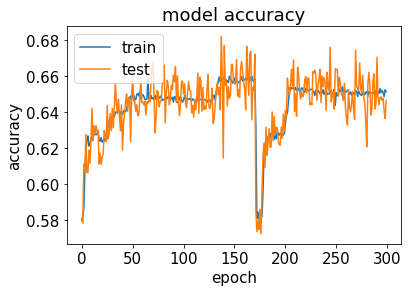

In [ ]:
plt.plot(history_w.history['accuracy'])
plt.plot(history_w.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

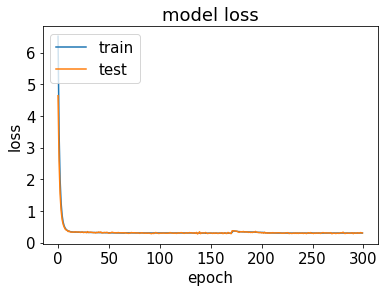

In [ ]:
plt.plot(history_w.history['loss'])
plt.plot(history_w.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

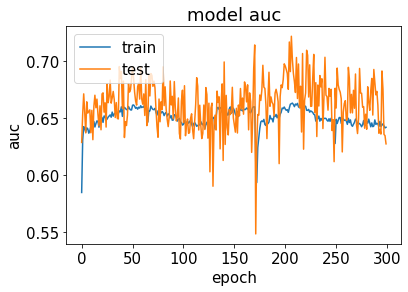

In [ ]:
plt.plot(history_w.history[list(history_w.history.keys())[2]])
plt.plot(history_w.history[list(history_w.history.keys())[5]])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# print(input_hrv_train.head())
# print(output_hrv_train.head())
# print(input_wearables_train.head())
# print(output_wearables_train.head())

## Combo Dataset Redo

In [ ]:
min_length = 4

rnn_combo_input = []
rnn_combo_output = []

# max_list_length = []
# for key in temp_df_hrv.keys():
#     this_length = 0
#     hrv_dates = list(temp_df_hrv[key].index)
#     for date in hrv_dates:
#         if date in df_covid.columns:
#             this_length += 1
#     max_list_length.append(this_length)
# max_list_length = sorted(max_list_length)
# print(max_list_length)

for key in temp_df_wearables.keys():
    covid_combo_np = []
    combo_np = []
    combo_dates_1 = list(temp_df_wearables[key].index)
    if key not in temp_df_hrv.keys():
        continue
    combo_dates_2 = list(temp_df_hrv[key].index)
    for date in combo_dates_1:
        if date in df_covid.columns and key in df_covid.index and date in combo_dates_2:
            covid_combo_np.append(df_covid.loc[key][date].astype('int'))
            # print(list(temp_df_wearables[key].loc[date].to_numpy()[:-1]))
            combo_np.append(list(temp_df_wearables[key].loc[date].to_numpy()[:-1].astype('float')) +
                            list(temp_df_hrv[key].loc[date].to_numpy().astype('float')))
    # print(hrv_np)
    # print(covid_hrv_np)

    #if len(covid_hrv_np) >= min_length:
    #    if 1 in covid_hrv_np:
    #        covid_index = covid_hrv_np.index(1)
    #        if covid_index+1 > min_length:
    #            rnn_hrv_input.append(hrv_np[covid_index-(min_length-1):covid_index+1])
    #            # rnn_hrv_output.append(covid_hrv_np[covid_index-(min_length-1):covid_index+1])
    #        else:
    #            rnn_hrv_input.append(hrv_np[:min_length])
    #            # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(1)
    #    else:
    #        rnn_hrv_input.append(hrv_np[:min_length])
    #        # rnn_hrv_output.append(covid_hrv_np[:min_length])
    #        rnn_hrv_output.append(0)

    # sliding window
    if len(covid_combo_np) >= min_length:
        for w in range(len(covid_combo_np) - min_length + 1):
            if covid_combo_np[w:w+min_length][-1] == 0 and covid_combo_np[w:w+min_length][0] == 1:
                continue
            rnn_combo_input.append(combo_np[w:w+min_length])
            rnn_combo_output.append(sum(covid_combo_np[w:w+min_length])/min_length)
            # if 1 in covid_hrv_np[w:w+min_length]:
            #     rnn_hrv_output.append(1)
            # else:
            #     rnn_hrv_output.append(0)

In [ ]:
# checking wearables data
print("Number of entries: " + str(len(rnn_combo_input)))

pos = sum(rnn_combo_output)

print("Positive: " + str(pos/len(rnn_combo_output)) + " Negative: " + str(1-pos/len(rnn_combo_output)))
#total_output = sum( [ len(c) for c in rnn_hrv_output])
# print(rnn_wearables_input)

Number of entries: 64
Positive: 0.625 Negative: 0.375


## Combo RNN

In [ ]:
# INPUTS
#cut_index = 4
# cut_index = int(len(rnn_hrv_input) * 0.4) # get more testing samples
cut_index_c = int(len(rnn_combo_input) * 0.1) # testing = 10% of our inputs

# print(rnn_combo_input[cut_index_w:])
# shuffle dataset
indices = tf.range(start=0, limit=len(rnn_combo_input), dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed=57344, name="combo_indices")
tf.print(shuffled_indices)

shuffled_rnn_combo_input = tf.gather(rnn_combo_input, shuffled_indices)
shuffled_rnn_combo_output = tf.gather(rnn_combo_output, shuffled_indices)

tmp_input_combo_train = tf.convert_to_tensor(shuffled_rnn_combo_input[cut_index_c:], dtype=tf.float32)
tmp_input_combo_val = tf.convert_to_tensor(shuffled_rnn_combo_input[:cut_index_c], dtype=tf.float32)

input_combo_train = layers.Input(shape=tmp_input_combo_train.shape,
                               tensor=tmp_input_combo_train)
input_combo_val = layers.Input(shape=tmp_input_combo_val.shape,
                             tensor=tmp_input_combo_val)

output_combo_train = tf.convert_to_tensor(shuffled_rnn_combo_output[cut_index_c:], dtype=tf.float32)
output_combo_val = tf.convert_to_tensor(shuffled_rnn_combo_output[:cut_index_c], dtype=tf.float32)

print(input_combo_train.shape, output_combo_train.shape)
print(input_combo_val.shape, output_combo_val.shape)
# print(input_combo_test.shape, output_combo_test.shape)

tmp_input_combo_tests = []
input_combo_tests = []
output_combo_tests = []
for i in range(0, cut_index_c):
    tmp_input_combo_tests.append(tf.convert_to_tensor([shuffled_rnn_combo_input[i]], dtype=tf.float32))
    input_combo_tests.append(layers.Input(shape=tmp_input_combo_tests[i].shape,
                                tensor=tmp_input_combo_tests[i]))
    output_combo_tests.append(tf.convert_to_tensor([shuffled_rnn_combo_output[i]], dtype=tf.float32))

(58, 4, 20) (58,)
(6, 4, 20) (6,)


In [ ]:
# MODEL
num_loops = 1

for i in range(num_loops):
    training_callbacks_c = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH_W,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    ]

    model_c = keras.Sequential()

    # LSTM Layer
    # model_c.add(layers.LSTM(input_hrv_val.shape[1], input_shape=input_hrv_val.shape[1:]))
    model_c.add(layers.SimpleRNN(input_combo_val.shape[1]*16, 
                            input_shape=input_combo_val.shape[1:], 
                            recurrent_regularizer=keras.regularizers.L2(0.1), 
                            activation='tanh'))
    # Dense Layer
    # kernel_regularizer=keras.regularizers.L2(0.01), 
    model_c.add(layers.Dense(input_combo_val.shape[1]*8,
                        kernel_regularizer=keras.regularizers.L2(0.05), 
                        activation='tanh'))
    model_c.add(layers.Dense(input_combo_val.shape[1]*2, 
                           activation='tanh'))
    model_c.add(layers.Dense(input_combo_val.shape[1],
                        activation='tanh'))
    # model_c.add(layers.Dense(input_hrv_val.shape[1], activation='tanh'))
    # if many-to-many, comment out this layer
    # Dense layer size 1 for BCE
    model_c.add(layers.Dense(1, activation='tanh'))

    # Binary Cross Entropy
    model_c.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                optimizer=tf.optimizers.SGD(),
                metrics=["accuracy", keras.metrics.AUC()])

    # Fit the model_c
    history_c = model_c.fit(input_combo_train, output_combo_train,
                        batch_size=1,
                        steps_per_epoch=input_combo_train.shape[0],
                        epochs=300,
                        validation_data=(input_combo_val, output_combo_val),
                        validation_steps=input_combo_val.shape[0],
                        callbacks = training_callbacks_c)

# Validation set loss & accuracy
results = model_c.evaluate(input_combo_val, output_combo_val, steps=input_combo_val.shape[0])
print("validation loss, acc: ", results)

# # Predict COVID in a witheld sample from the training set
for i in range(0, cut_index_c):
    prediction = model_c.predict(input_combo_tests[i], output_combo_tests[i], steps=1)
    print(i, " test actual, prediction: ", rnn_combo_output[i], prediction[0])
    # print(i, " test prediction: ", prediction)

prediction = model_c.predict(input_combo_val, output_combo_val, steps=1)
# print(rnn_hrv_output[:cut_index_c], prediction)
print("f1 score: ", f1_score(rnn_combo_output[:cut_index_c], prediction, 0.125))

print(model_c.summary())

Train on 58 samples, validate on 6 samples
Epoch 1/300
58/58 [==============================] - 1s 16ms/step - batch: 28.5000 - size: 1.0000 - loss: 8.1410 - accuracy: 0.5098 - auc_2: 0.5660 - val_loss: 7.3203 - val_accuracy: 0.6389 - val_auc_2: 0.5788
Epoch 2/300
58/58 [==============================] - 0s 3ms/step - batch: 28.5000 - size: 1.0000 - loss: 6.6729 - accuracy: 0.6106 - auc_2: 0.6477 - val_loss: 6.0939 - val_accuracy: 0.5278 - val_auc_2: 0.6734
Epoch 3/300
58/58 [==============================] - 0s 4ms/step - batch: 28.5000 - size: 1.0000 - loss: 5.5268 - accuracy: 0.6097 - auc_2: 0.6876 - val_loss: 5.0451 - val_accuracy: 0.5278 - val_auc_2: 0.6510
Epoch 4/300
58/58 [==============================] - 0s 4ms/step - batch: 28.5000 - size: 1.0000 - loss: 4.6038 - accuracy: 0.6076 - auc_2: 0.7259 - val_loss: 4.1884 - val_accuracy: 0.6389 - val_auc_2: 0.5082
Epoch 5/300
58/58 [==============================] - 0s 3ms/step - batch: 28.5000 - size: 1.0000 - loss: 3.8538 - accura

In [ ]:
# print result using best model
# Loads the weights
model_c.load_weights(CHECKPOINT_PATH)

# Validation set loss & accuracy
results = model_c.evaluate(input_combo_val, output_combo_val, steps=input_combo_val.shape[0])
print("validation loss, acc, auc: ", results)

# # Predict COVID in a witheld sample from the training set
for i in range(0, cut_index_c):
    prediction = model_c.predict(input_combo_tests[i], output_combo_tests[i], steps=1)
    print(i, " test actual, prediction: ", rnn_combo_output[i], prediction[0])
    # print(i, " test prediction: ", prediction)

prediction = model_c.predict(input_combo_val, output_combo_val, steps=1)
# print(rnn_hrv_output[:cut_index], prediction)
print("precision: ", precision(rnn_combo_output[:cut_index_c], prediction, 0.125))
print("recall: ", recall(rnn_combo_output[:cut_index_c], prediction, 0.125))
print("f1 score: ", f1_score(rnn_combo_output[:cut_index_c], prediction, 0.125))

validation loss, acc, auc:  [0.15715149541695914, 0.8888889, 0.8489584]
0  test actual, prediction:  0.25 [0.95433086]
1  test actual, prediction:  0.5 [0.95433086]
2  test actual, prediction:  1.0 [0.6598532]
3  test actual, prediction:  1.0 [-0.03755715]
4  test actual, prediction:  0.75 [0.95870686]
5  test actual, prediction:  1.0 [0.9971713]
precision:  0.4
recall:  0.6666666666666666
f1 score:  0.5


In [ ]:
print(history_c.history.keys())

dict_keys(['loss', 'accuracy', 'auc_2', 'val_loss', 'val_accuracy', 'val_auc_2'])


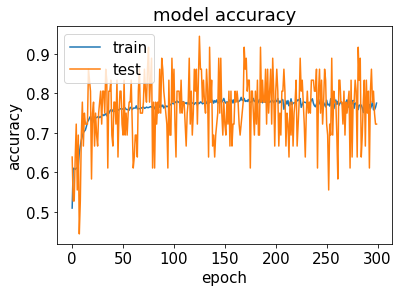

In [ ]:
plt.plot(history_c.history['accuracy'])
plt.plot(history_c.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

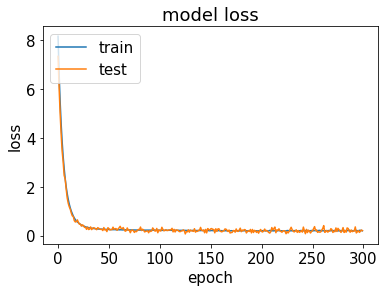

In [ ]:
plt.plot(history_c.history['loss'])
plt.plot(history_c.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

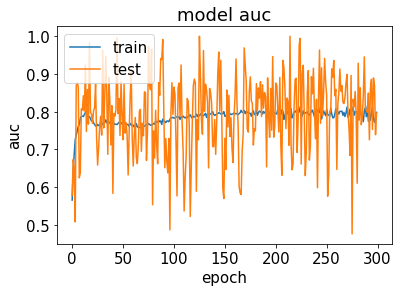

In [ ]:
plt.plot(history_c.history[list(history_c.history.keys())[2]])
plt.plot(history_c.history[list(history_c.history.keys())[5]])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()